# Image Classifier

In [1]:
!pip install -Uqq fastai duckduckgo_search

## Download images from DuckDuckGo

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images = 30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot("image")

Download the images and take a look at it.

Searching for 'cigarette smoke'


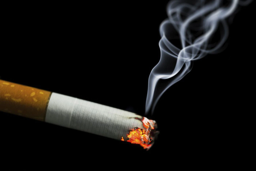

In [3]:
from fastdownload import download_url
from fastai.vision.all import *

download_url(search_images("cigarette smoke", max_images=1)[0], 'csmoke.jpg', show_progress=False)
Image.open('csmoke.jpg').to_thumb(256, 256)

Searching for 'incense smoke'


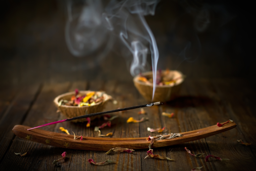

In [4]:
download_url(search_images("incense smoke", max_images=1)[0], 'ismoke.jpg', show_progress=False)
Image.open('ismoke.jpg').to_thumb(256, 256)

The search gives reasonable results, so let's take a few images of "cigarette smoke" and "incense smoke" and save each group of images to a different folder.

In [7]:
searches = "cigarette smoke", "incense smoke"
path = Path("smoke")
from time import sleep

for i in searches:
    dest = (path/i)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f"{i}"))
    resize_images(path/i, max_size=400, dest=path/i)

Searching for 'cigarette smoke'
Searching for 'incense smoke'


## Training our model

Some images might not download correctly which could cause our model training to fail, so we'll remove them:

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need DataLoaders, which is an object that contains a training set and a validation set. In fastai we can create that easily using a DataBlock, and view sample images from it:

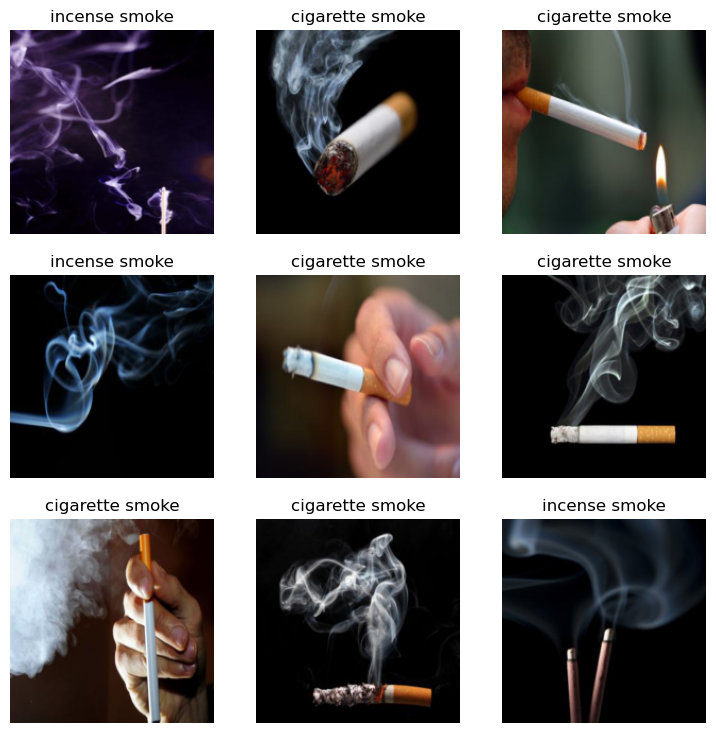

In [9]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms = [Resize(192, method = 'squish')]).dataloaders(path, bs=32)

dls.show_batch(max_n = 9)

blocks=(ImageBlock, CategoryBlock),
The inputs to our model are images, and the outputs are categories

get_items=get_image_files, 
To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).

splitter=RandomSplitter(valid_pct=0.2, seed=42),
Split the data into training and validation sets randomly, using 20% of the data for the validation set.

get_y=parent_label,
The labels (y values) is the name of the parent folder of each file.

item_tfms=[Resize(192, method='squish')],
Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is resnet18.
fine_tune() method automatically uses best practices for fine tuning a pre-trained model.

In [ ]:
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
